# ***Regresyon Projesi***

## ***Ev Fiyatlari***

Veri seti [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)'dan elde edilmistir.

***Proje Adimlari***

- Kesifsel veri analizi adimlari (veri temizligi, veri kesfi ve ozellik muhendisligi) [burada](https://github.com/ahmetpergamum/datascience/blob/master/04_eda_project_house_prices/eda_house_prices.ipynb) yapilmis, outlier temizligi [burada] yapilmis, gerektiginde bu adimlar tekrarlanmistir.

- Veriler eğitim ve test kümelerine ayrilmistir. Verilerin %20 si rasgele secilerek test kumesi olusturulmustur.

- Açıklayıcı değişken olarak seçtiğimiz değişkenleri kullanarak bir regresyon modeli tahmin edilmistir.
    - Modelin lineer regresyon varsayimlarini karsilama durumuna bakilmistir. Karsilanmayan varsayimlar varsa model iyilestirilmeye calisilmistir.
    - Denenen değişik modellerden en iyisi olduğu dusunulen model secilmistir. 

- Secilen model ile test kümesindeki veriler kullanarak tahmin yapilmis, tahmin performansi RMSE gibi metrikleri kullanilarak sayisal olarak değerlendirilmistir. Tahmin edilen değerler ile gerçek değerler bir grafik üzerinde cizdirilerek model analiz edilmisitir.


---

In [308]:
import pandas as pd
import numpy as np
# grafiksel araclar
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set(style="whitegrid")
# lineer regresyon icin
from sklearn import linear_model
import statsmodels.api as sm
# polynomial features icin
from sklearn.preprocessing import PolynomialFeatures
# egitim verisini ayirmak icin
from sklearn.model_selection import train_test_split
# tahmin performansi icin
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
# regularizasyon icin
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# path ile calismak icin
import sys
# dosyanin bulundugu dizini path e ekledik
mylib = '/home/admin1/datascience/datascience/library'
if mylib not in sys.path:
    sys.path.insert(1, mylib)
# parser i kullanabilmek icin
from data_description_parser import data_description_house_prices
data_dict = data_description_house_prices()

# uyarilari dikkate alma
import warnings
warnings.filterwarnings('ignore')

# pandas varsayilan olarak cok sayida sutun veya satir varsa tumunu gostermez
# bu nedenle 100 sutun ve satir gostermesi icin
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# virgulden sonra belirli sayida basamak gosterimi icin 
pd.options.display.float_format = '{:,.3f}'.format
# aciklama sutunun tam cikmasi icin
pd.options.display.max_colwidth = 100

# font tanimlamalari
title_font = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 14}
axis_font  = {'family': 'times new roman', 'color': 'darkred','weight': 'bold','size': 14}

# temiz veri setini dataframe icerisine yukle
house_prices = pd.read_csv('data/house_prices_out.csv',index_col='Id')

# object tipinde olanlar kategorik degiskenler listesine ayir
qualitative = [column for column in house_prices.columns if house_prices.dtypes[column] == 'object']

# object tipinde olanlar kategorik degiskenler listesine ayir
quantitative = [column for column in house_prices.columns if house_prices.dtypes[column] != 'object']

- Sonuclar dataframe olusturularak kaydedilecek.

In [309]:
# performans sonuclarini tutacak df
results_df = pd.DataFrame(columns=['description', 'rsquared',
                                   'MAE', 'MSE', 'RMSE', 'MAPE'])
results_df.index.name = 'model' 
 

In [310]:
# sonuclari kaydeden fonksiyon
def save_results(results, model_nu, y_test, y_test_pred, description):
    # global degiskeni degistirmek istiyorsak fonksiyon icersinde bu tanimlama olmali
    global results_df
    new = 0
    # model_nu varsa ustune yaz yoksa yeni olustur concat et
    if ((results_df.index == model_nu).any()):
        df = results_df
    else:
        df = pd.DataFrame([])
        df.index.name = 'model'
        new = 1
    df.loc[model_nu,'description'] = description
    df.loc[model_nu,'rsquared'] = results.rsquared
    df.loc[model_nu,'MAE'] = mean_absolute_error(y_test, y_test_pred)
    df.loc[model_nu,'MSE'] = mse(y_test, y_test_pred)
    df.loc[model_nu,'RMSE'] = rmse(y_test, y_test_pred)
    df.loc[model_nu,'MAPE'] = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
        
    if new == 1:        
        results_df = pd.concat([results_df, df])

# tahmin sonuclarini tutacak dataframe
predict_df = pd.DataFrame(columns=['model_nu', 'real_value', 'prediction_value', 
                                   'type', 'description'])

# sonuclari kaydeden fonksiyon
def save_pred_results(model_nu, y_test, y_test_pred, y_train, y_train_pred, description):
    # global degiskeni degistirmek istiyorsak fonksiyon icersinde bu tanimlama olmali
    global predict_df
    new = 0    
    train_nu = y_train.shape[0]
    test_nu = y_test.shape[0]
    row_nu = train_nu + test_nu
    # model_nu varsa ustune yaz yoksa yeni olustur concat et
    if ((predict_df.model_nu == model_nu).any()):
        df = predict_df
    else:
        df = pd.DataFrame([])
        new = 1
    df['model_nu'] = [model_nu for i in range(row_nu)]
    df['description'] = [description for i in range(row_nu)]
    df['type'] = ['train'  if i<train_nu else 'test' for i in range(row_nu)]
    # series oldugundan degerleri array seklinde almak icin .values kullandik
    df.loc[df['type']=='train', 'real_value'] = y_train.values
    df.loc[df['type']=='train', 'prediction_value'] = y_train_pred  
    # series oldugundan degerleri array seklinde almak icin .values kullandik
    df.loc[df['type']=='test', 'real_value'] = y_test.values
    df.loc[df['type']=='test', 'prediction_value'] = y_test_pred
        
    if new == 1:        
        predict_df = pd.concat([predict_df, df])
        
        
def make_plotly(df):
    fig = px.scatter(df, x='real_value', y='prediction_value', color='type')
    fig.add_trace(go.Scatter(x=df['real_value'], y=df['real_value'], mode='lines',
                    name='real_line', opacity=0.5))    
    fig.update_layout(width=1200,  height=600, title_text='Model Performance')
    #fig.update_xaxes(range=[1000, 760000])
    #fig.update_yaxes(range=[1000, 760000])
    fig.show()
        
        
def make_plot(y_test, y_test_pred, y_train, y_train_pred):   
    plt.figure(dpi = 100)
    plt.scatter(y_train, y_train_pred, label='train')
    plt.scatter(y_test, y_test_pred, alpha=0.5, label='test')    
    plt.plot(y_test, y_test, color="red", label='real')
    plt.xlabel("Gerçek Değerler", fontdict=axis_font)
    plt.ylabel("Tahmin edilen Değerler", fontdict=axis_font)
    plt.annotate('RMSE test  : {:.2f}'.format(rmse(y_test,y_test_pred)), xy=(600000,200000))
    plt.annotate('RMSE train : {:.2f}'.format(rmse(y_train,y_train_pred)), xy=(600000,100000))
    plt.title("Satis Fiyati: Gerçek ve tahmin edilen değerler", fontdict=title_font)
    plt.legend(loc='upper left')
    plt.show()
    

def encode(df, feature):
    ordering = pd.DataFrame()
    ordering['val'] = df[feature].unique()
    # degerler index yapildi
    ordering.index = ordering.val
    # degisken degerlerinin SalePrice ortalamalarini aliyor
    ordering['spmean'] = df[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    # ortalamalari siraliyor
    ordering = ordering.sort_values('spmean')
    # siralama degerleri ayri bir sutunda
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    #print(ordering)
    ordering = ordering['ordering'].to_dict()    
    # en son soyle bir sozluk olusur ExterQual icin
    # {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
    
    # burasi cok ilginc yeni encoded degiskeni burada olusturuyor
    for cat, o in ordering.items():        
        df.loc[df[feature] == cat, feature+'_E'] = o

In [311]:
qual_encoded = []
for q in qualitative:  
    encode(house_prices, q)
    qual_encoded.append(q+'_E')

quantitative.remove('SalePrice')
expl_vars = []
expl_vars = quantitative + qual_encoded


print('Min satis fiyati : {}\nMax satis fiyati : {}'.format(house_prices['SalePrice'].min(),
                                                            house_prices['SalePrice'].max()))

print('Aciklayici degisken adedi : {}'.format(len(expl_vars)))


Min satis fiyati : 34900
Max satis fiyati : 485000
Aciklayici degisken adedi : 79


In [312]:
# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

# statsmodel kullanarak lrm
# bias (intercept) değişkenini manuel olarak ekliyoruz
# egitim verisi ile model olusturma
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()


In [313]:
vars_to_remove = []
# p degerleri yuksek olanlari cikar
for var in expl_vars:
    if results.pvalues[var]>0.05:
        vars_to_remove.append(var)
        
# istenmeyenleri ayir
for var in vars_to_remove:
    if var in expl_vars:
        expl_vars.remove(var) 

In [314]:
len(expl_vars)

34

Eğitim kümesindeki gözlem sayısı : (1128, 34)
Test kümesindeki gözlem sayısı   : (283, 34)


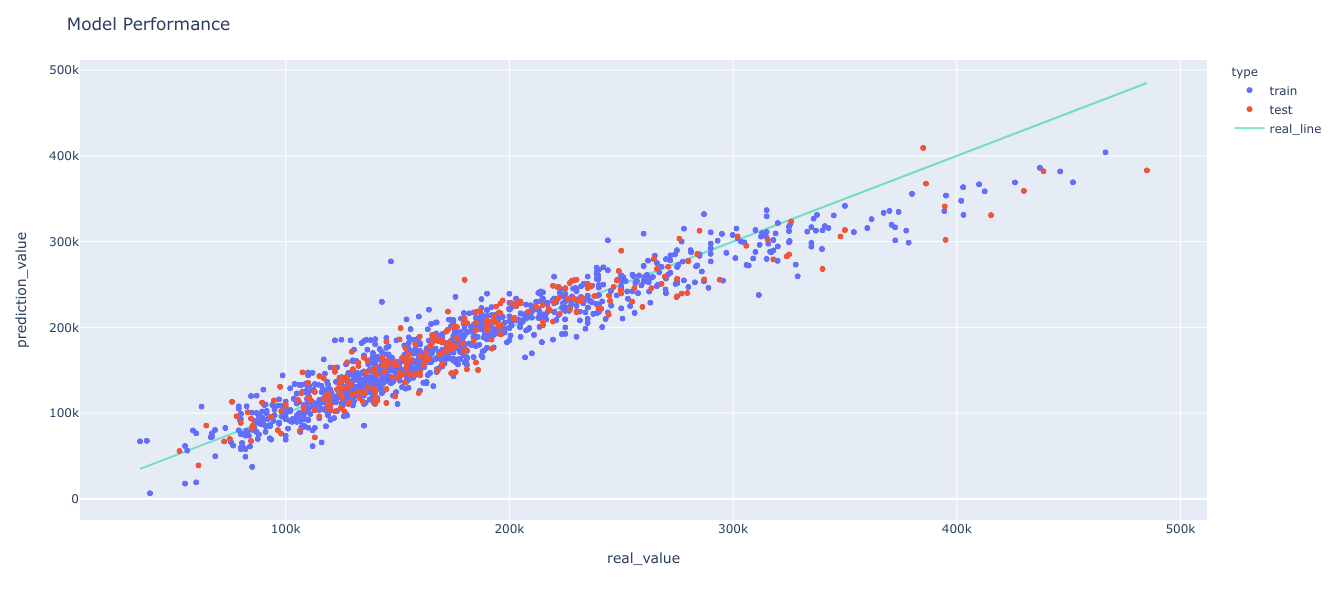

,description,rsquared,MAE,MSE,RMSE,MAPE
model,,,,,,
1,butun anlamli degiskenler,0.911,"17,398.481","531,304,469.976","23,050.043",10.098


In [315]:
# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape))

# model nesnesi olusturuldu
lrm = linear_model.LinearRegression()
# modelimizin denklemi (egrisi) olusturuluyor
lrm.fit(X_train, Y_train)

# test verisi ile tahmin
Y_test_pred = lrm.predict(X_test)
# egitim verisi ile tahmin
Y_train_pred = lrm.predict(X_train)

save_pred_results(1, Y_test, Y_test_pred, Y_train, Y_train_pred, 'butun anlamli degiskenler')

# grafigi cizdirelim
make_plotly(predict_df)
#predict_df.info()

# statsmodel kullanarak lrm
# bias (intercept) değişkenini manuel olarak ekliyoruz
# egitim verisi ile model olusturma
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()

# model sonuclarini kaydedelim
save_results(results, 1, Y_test, Y_test_pred, 'butun anlamli degiskenler')

# model sonuclari
results_df

Eğitim kümesindeki gözlem sayısı : (1128, 32)
Test kümesindeki gözlem sayısı   : (283, 32)


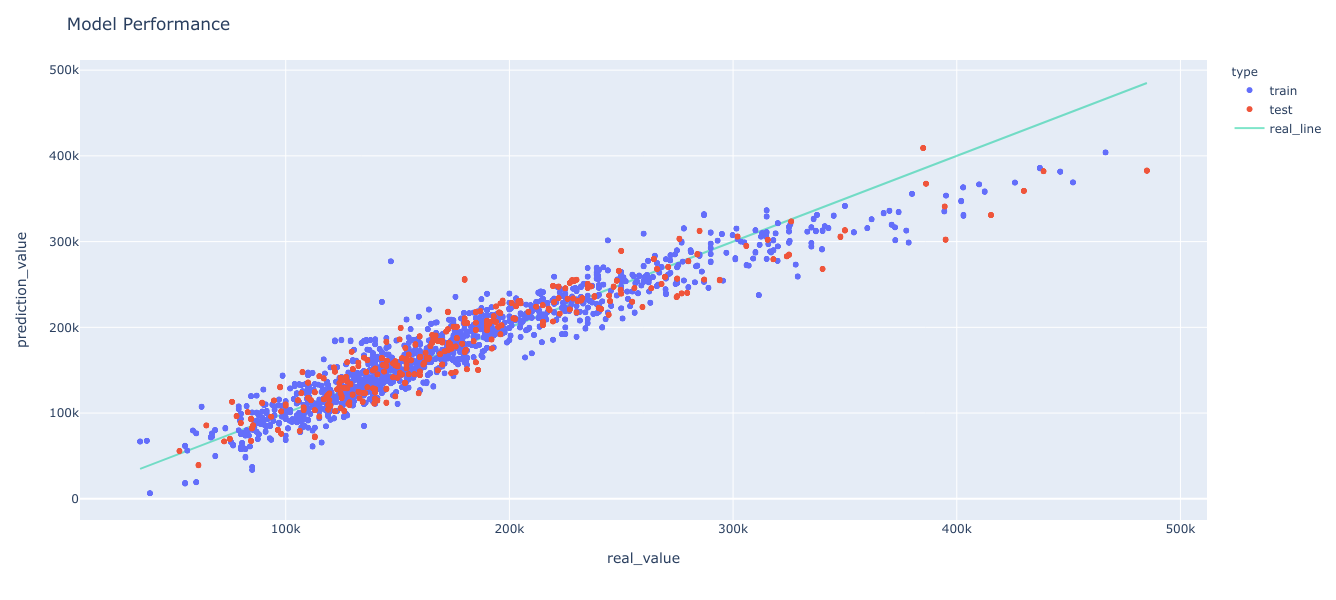

,description,rsquared,MAE,MSE,RMSE,MAPE
model,,,,,,
1,butun anlamli degiskenler,0.911,"17,398.481","531,304,469.976","23,050.043",10.098
2,butun anlamli degiskenler,0.911,"17,394.021","531,133,085.037","23,046.325",10.090


In [316]:


expl_vars.remove('Utilities_E')
expl_vars.remove('PoolQC_E')

# hedef degiskeni
Y = house_prices['SalePrice']
# aciklayici degiskenler
X = house_prices[expl_vars]

# egitim verisini ayirma
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("Eğitim kümesindeki gözlem sayısı : {}".format(X_train.shape))
print("Test kümesindeki gözlem sayısı   : {}".format(X_test.shape))

# model nesnesi olusturuldu
lrm = linear_model.LinearRegression()
# modelimizin denklemi (egrisi) olusturuluyor
lrm.fit(X_train, Y_train)

# test verisi ile tahmin
Y_test_pred = lrm.predict(X_test)
# egitim verisi ile tahmin
Y_train_pred = lrm.predict(X_train)

save_pred_results(2, Y_test, Y_test_pred, Y_train, Y_train_pred, 'butun anlamli degiskenler')

# grafigi cizdirelim
make_plotly(predict_df)
#predict_df.info()

# statsmodel kullanarak lrm
# bias (intercept) değişkenini manuel olarak ekliyoruz
# egitim verisi ile model olusturma
X_train = sm.add_constant(X_train)
results = sm.OLS(Y_train, X_train).fit()

# model sonuclarini kaydedelim
save_results(results, 2, Y_test, Y_test_pred, 'butun anlamli degiskenler')

# model sonuclari
results_df

Id
366     1344
486     1113
505     1322
614     1120
857     1026
1086     996
1228     912
1309    1122
1325    1795
Name: GrLivArea, dtype: int64